# Data

Ce notebook gère la création des données d'entraînement et de tests.

In [4]:
import ipywidgets as widgets
from ipywidgets import interact
from src.metrics import *
from src.utils import *
import lazypredict
from PIL import Image
from sklearn.utils import shuffle
from collections import defaultdict

Paramètres :

In [27]:
x = 4500
y = 1600
width = 10000
height = 5000

files = ["BSE", "Fe", "S", "O", "Mg", "Ca", "Al", "Si"]

features = [
    "BSE", "Ca", "Al", "Mg", "Si", "Fe", "S", "O",
    #"g Ca", "g Al",
    #"g BSE",
    #"g Mg", "g Si", "g Fe", "g S", "g O",
    #"= Mg / (Mg + Fe + Ca + 0.0000001)", "= Mg / (Si + + 0.0000001)", "= Mg / (Fe + + 0.0000001)","= Ca / (Al + 0.0000001)", "= Fe / (Si + + 0.0000001)"
]

tile_size = 50          # taille des blocs pour split spatial
train_ratio = 0.7       # proportion de blocs pour le train
max_samples_per_class = 4000
patch_W = 9             # taille des patches

In [28]:
images = load_images(x, y, width, height, files)
data = compute_features(images, features)

In [29]:
# --- Paramètres ---
base_dir = "raw/labels/"
label_paths = ["FeSO_Labels.png", "MgCaAl_Labels.png", "MgSiS_Labels.png", "output_Labels.png"]

# --- Étape 1 : lecture et collecte des coordonnées/labels ---
coords_list, labels_list = [], []

for label_path in label_paths:
    label_img = Image.open(base_dir + label_path).convert('L')
    label_array = np.array(label_img)
    coords = np.argwhere(label_array != 0)
    labels = label_array[coords[:,0], coords[:,1]]
    
    coords_list.append(coords)
    labels_list.append(labels)

coords_all = np.vstack(coords_list)
labels_all = np.hstack(labels_list)

H, W_img, _ = data.shape

# --- Étape 2 : split spatial par blocs ---
# Découpage en blocs
tiles_x = W_img // tile_size
tiles_y = H // tile_size

# Générer les indices de blocs
block_indices = [(i, j) for i in range(tiles_y) for j in range(tiles_x)]
np.random.seed(42)
np.random.shuffle(block_indices)

n_train_blocks = int(len(block_indices) * train_ratio)
train_blocks = set(block_indices[:n_train_blocks])
test_blocks  = set(block_indices[n_train_blocks:])

def assign_block(y, x):
    block_y = y // tile_size
    block_x = x // tile_size
    return (block_y, block_x)

train_mask = np.array([assign_block(y, x) in train_blocks for y, x in coords_all])
test_mask  = np.array([assign_block(y, x) in test_blocks for y, x in coords_all])

coords_train, labels_train = coords_all[train_mask], labels_all[train_mask]
coords_test,  labels_test  = coords_all[test_mask],  labels_all[test_mask]

# --- Étape 3 : appliquer le maximum global par classe ---
def limit_per_class(coords, labels, max_samples):
    coords_out, labels_out = [], []
    counter = defaultdict(int)
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    
    for idx in indices:
        label = labels[idx]
        if counter[label] < max_samples:
            coords_out.append(coords[idx])
            labels_out.append(label)
            counter[label] += 1
    return np.array(coords_out), np.array(labels_out)

coords_train, labels_train = limit_per_class(coords_train, labels_train, max_samples_per_class)
coords_test,  labels_test  = limit_per_class(coords_test,  labels_test,  max_samples_per_class)

# --- Étape 4 : extraction des patches ---
def extract_patch(data, x, y, W):
    if W == 1:
        return data[y, x, :][None, None, :]
    half = W // 2
    H, W_img, _ = data.shape
    if x < half or y < half or x >= W_img - half or y >= H - half:
        return None
    return data[y-half:y+half+1, x-half:x+half+1, :]

def build_dataset(coords, labels, data, W):
    X, y = [], []
    for (y_coord, x_coord), label in zip(coords, labels):
        patch = extract_patch(data, x_coord, y_coord, W)
        if patch is not None:
            X.append(patch)
            y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = build_dataset(coords_train, labels_train, data, patch_W)
X_test,  y_test  = build_dataset(coords_test,  labels_test,  data, patch_W)

# --- Étape 5 : shuffle final ---
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test,  y_test  = shuffle(X_test,  y_test,  random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (33919, 9, 9, 8) (33919,)
Test : (19398, 9, 9, 8) (19398,)


---

# Class Plot

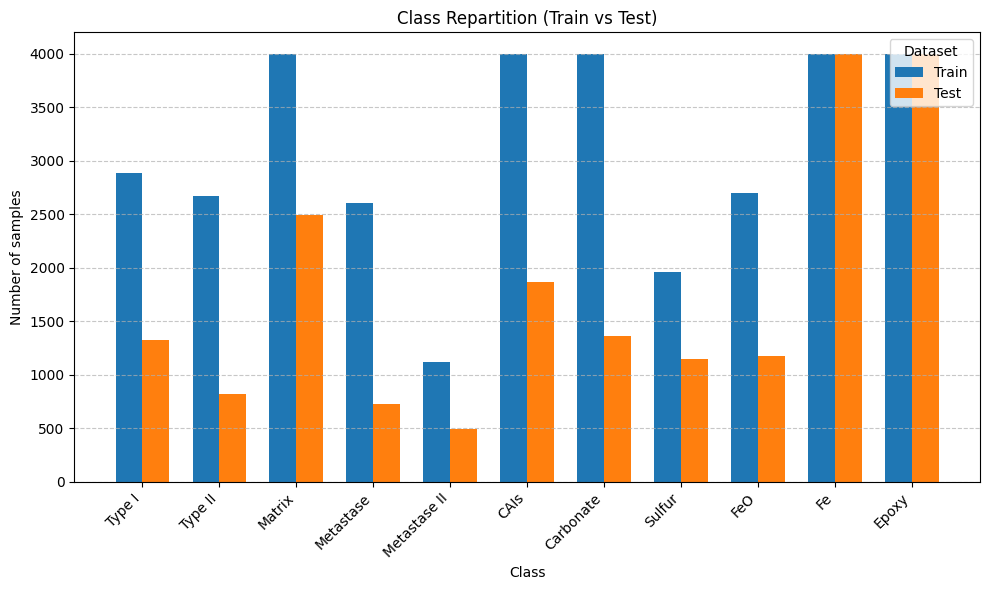

In [30]:
from collections import Counter

labels = [
    "",
    "Type I",
    "Type II",
    "Matrix",
    "Metastase",
    "Metastase II",
    "CAIs",
    "Carbonate",
    "Sulfur",
    "FeO",
    "Fe",
    "Epoxy"
]

# Comptage séparé
counts_train = Counter(y_train)
counts_test = Counter(y_test)

# Classes présentes
class_indices = sorted(set(counts_train.keys()) | set(counts_test.keys()))
class_names = [labels[i] for i in class_indices]

# Récupère les valeurs
train_vals = [counts_train.get(i, 0) for i in class_indices]
test_vals = [counts_test.get(i, 0) for i in class_indices]

# Plot côte à côte
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(10, 6))
bars_train = plt.bar(x - width/2, train_vals, width, label='Train')
bars_test = plt.bar(x + width/2, test_vals, width, label='Test')

plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Repartition (Train vs Test)')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend(title='Dataset', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
np.save('X.npy', X_train)
np.save('y.npy', y_train)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)